Movie Review Sentiment Analysis (Kernels Only)

In [40]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import nltk
from tensorflow.keras.preprocessing.text import Tokenizer

In [31]:
data_dir = os.path.join('datasets', 'stack_exchange')
os.listdir(data_dir)

['sampleSubmission.csv', 'test.tsv', 'train.tsv']

In [33]:
train_path = os.path.join(data_dir, 'train.tsv')
train_df = pd.read_csv(train_path, sep='\t')

test_path = os.path.join(data_dir, 'test.tsv')
test_df = pd.read_csv(test_path, sep='\t')

train_df.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [34]:
train_df.isna().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

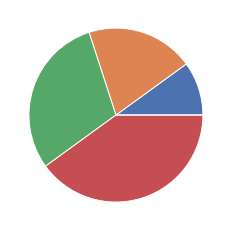

In [41]:
plt.pie(train_df['Sentiment'].unique());

In [44]:
test_df['Sentiment'] = -1
total_df = pd.concat([train_df, test_df])

In [45]:
tokenizer = Tokenizer(lower=True, filters='')
tokenizer.fit_on_texts(total_df['Phrase'])
total_df['tokens'] = tokenizer.texts_to_sequences(total_df['Phrase'])